In [1]:
import pandas as pd
import numpy as np #Funções matemáticas
import seaborn as sns #Gerar gráficos
import matplotlib.pyplot as plt #Gerar gráficos
import pickle #Gravar variáveis
from sklearn.cluster import KMeans #Realizar a segmentação do mercado / Agrupamento dos clientes
from sklearn.decomposition import PCA #Reduzir a dimensionalidade dos dados

In [2]:
def open_cluster_centers():
  #carregando arquivos
  with open('agrupamentos_clientes.pkl','rb') as f:
    return pickle.load(f)

In [3]:
cluster_centers, creditcard_df, creditcard_scaled_df, labels, n_clusters, wcss_1 = open_cluster_centers()

In [4]:
#Adicionando a classificação do agrupamento nos respectivos clientes
creditcard_df_cluster = pd.concat([creditcard_df, pd.DataFrame({'cluster': labels})], axis=1) #axis: colocar os dados numa outra coluna
creditcard_df_cluster.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,6
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,4
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,6
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,6


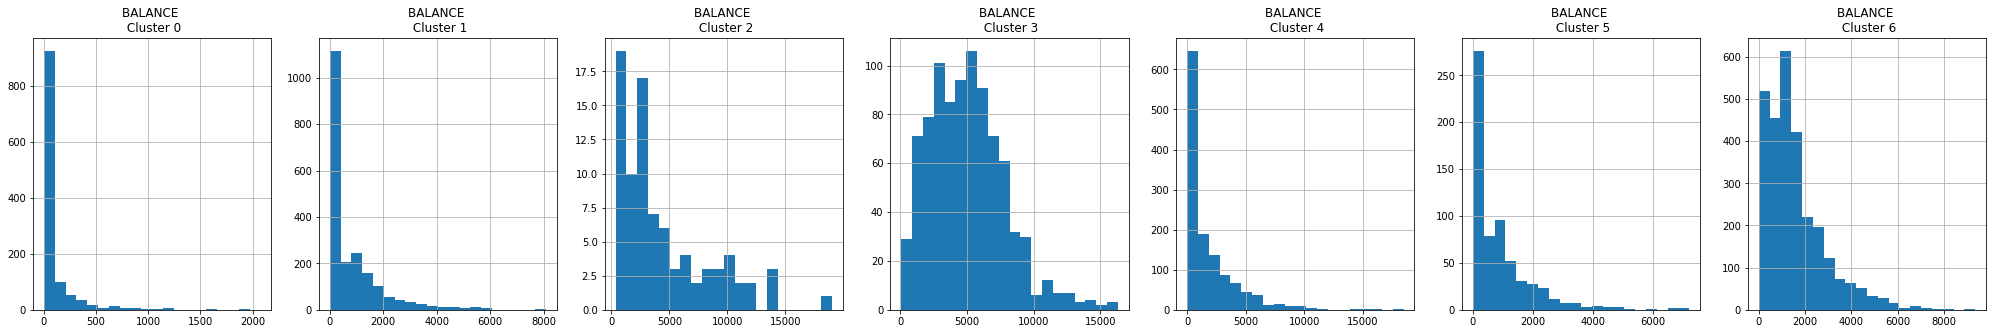

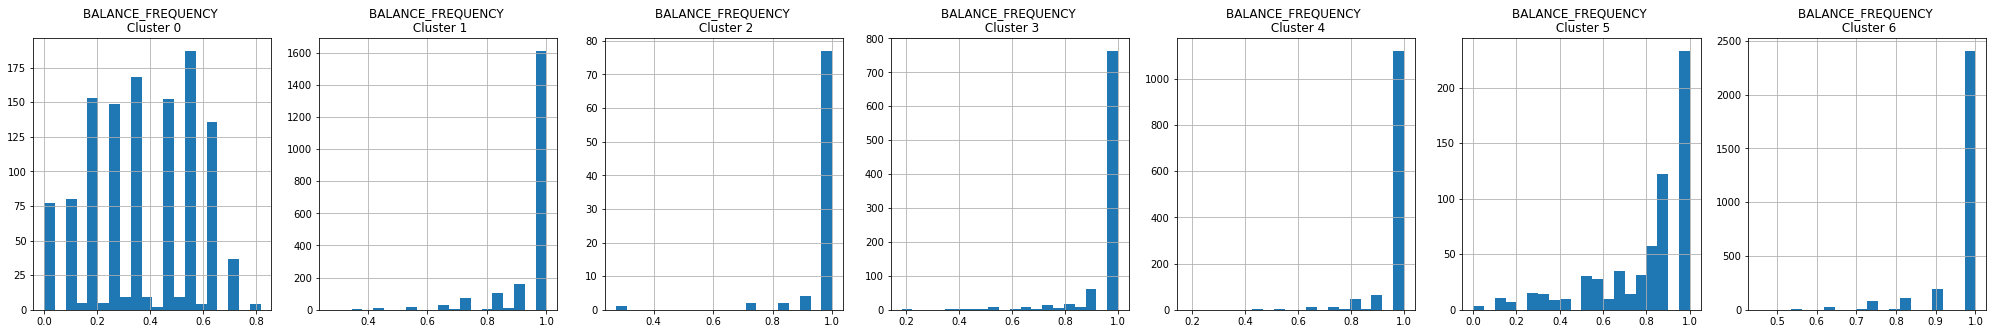

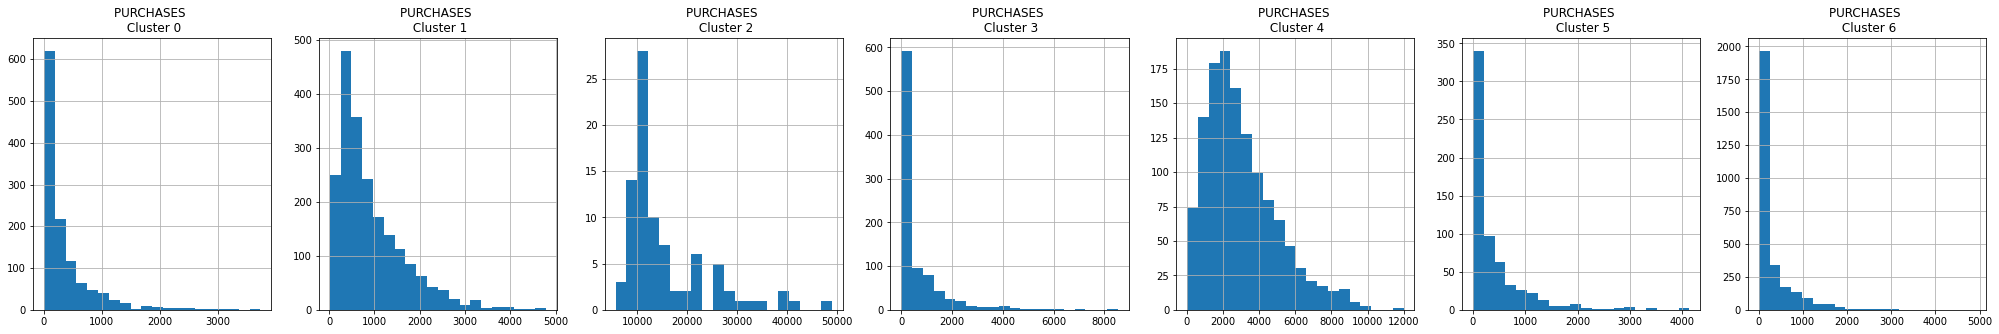

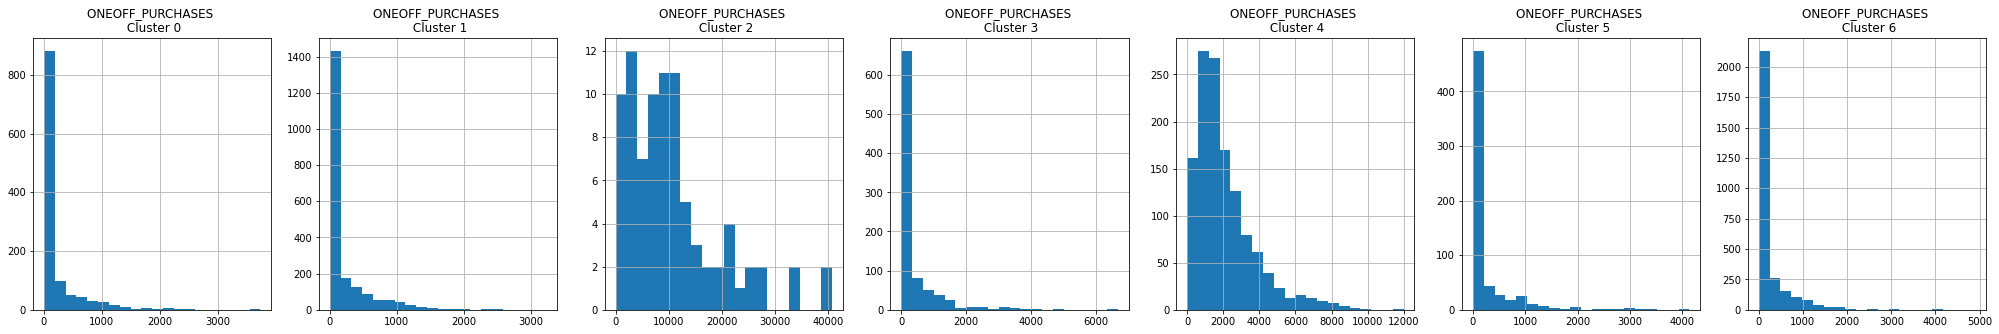

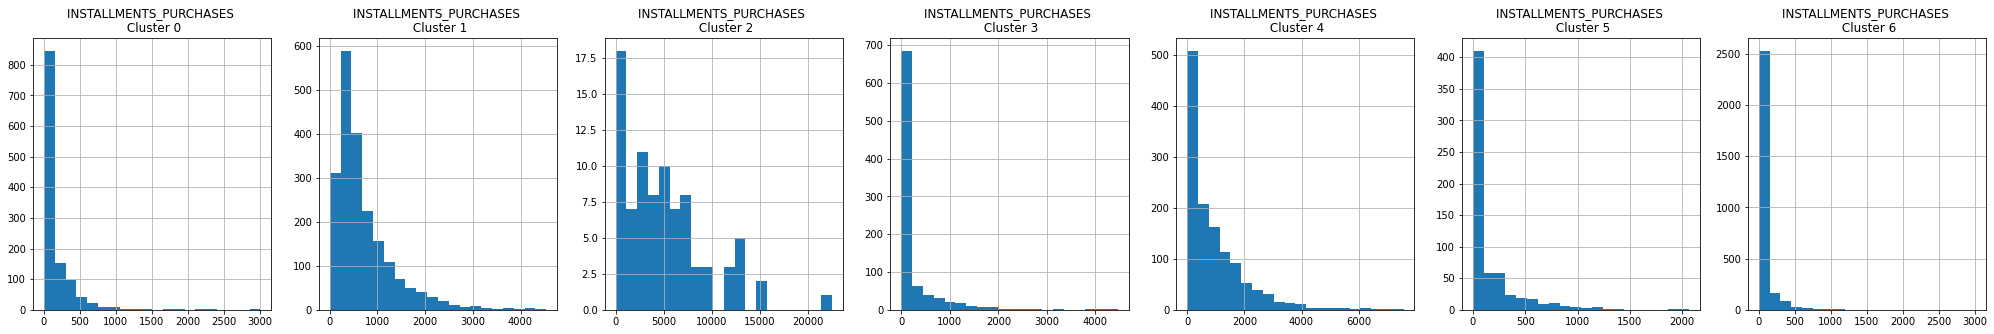

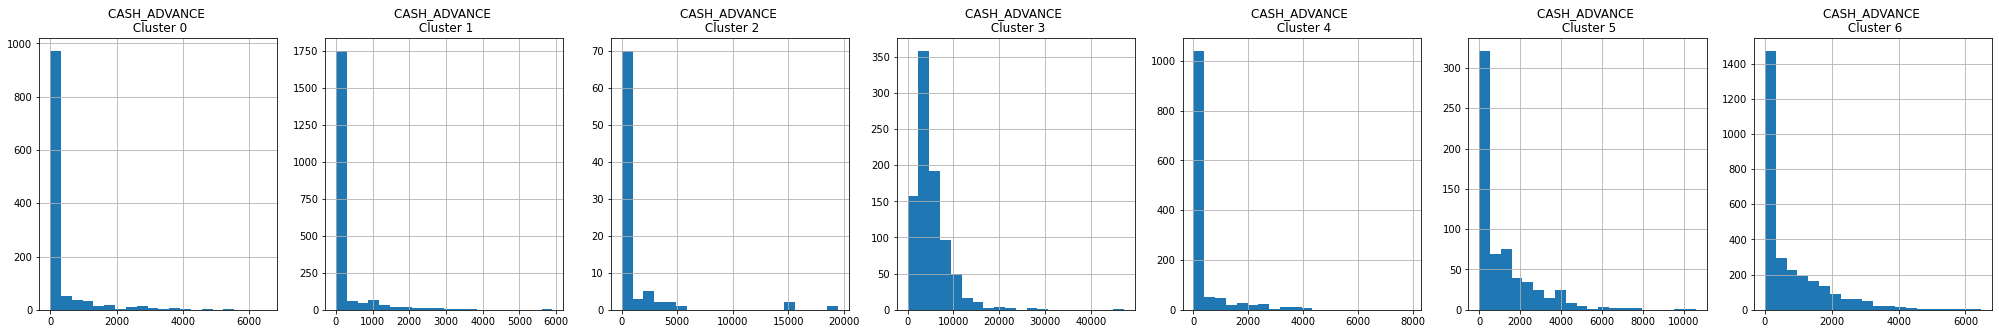

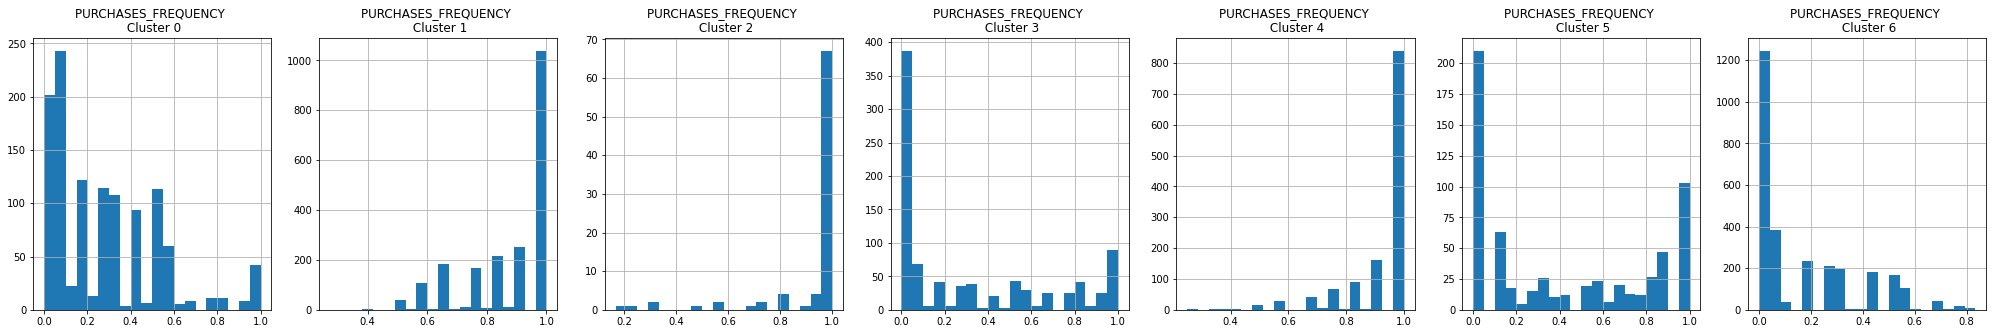

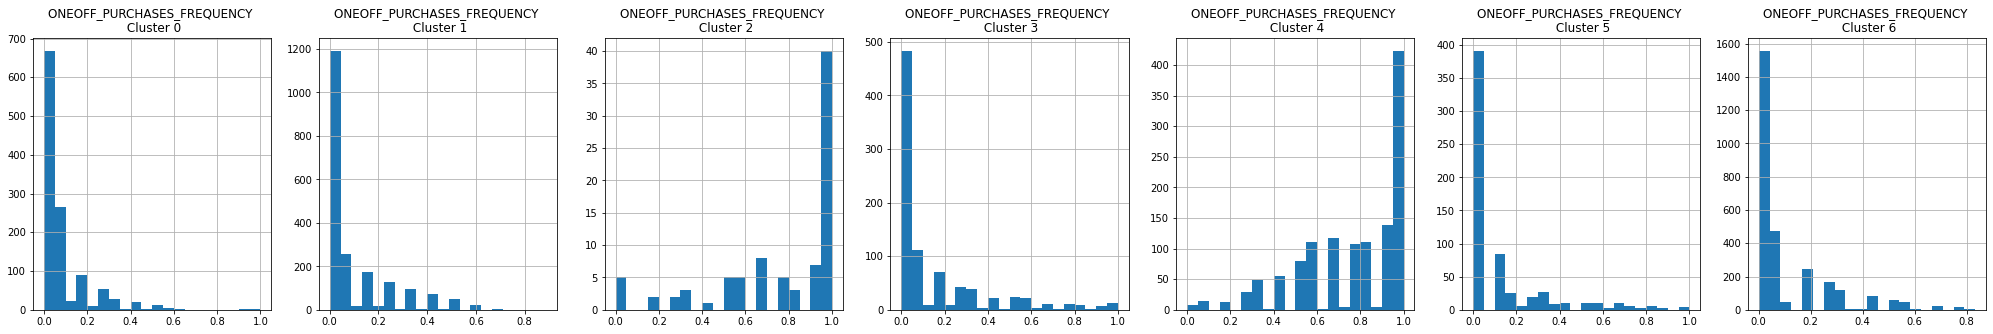

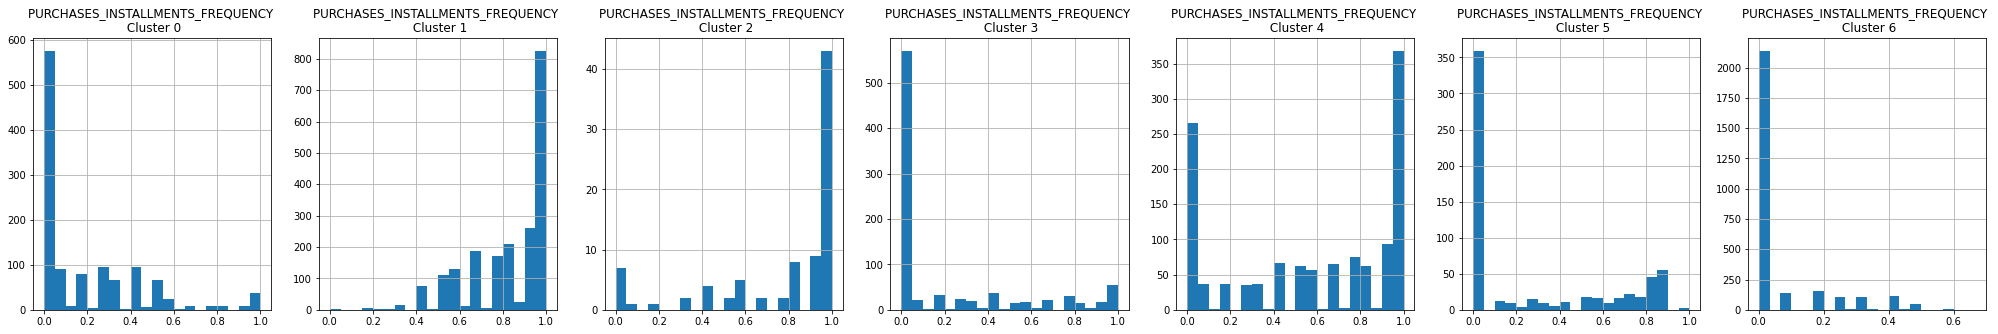

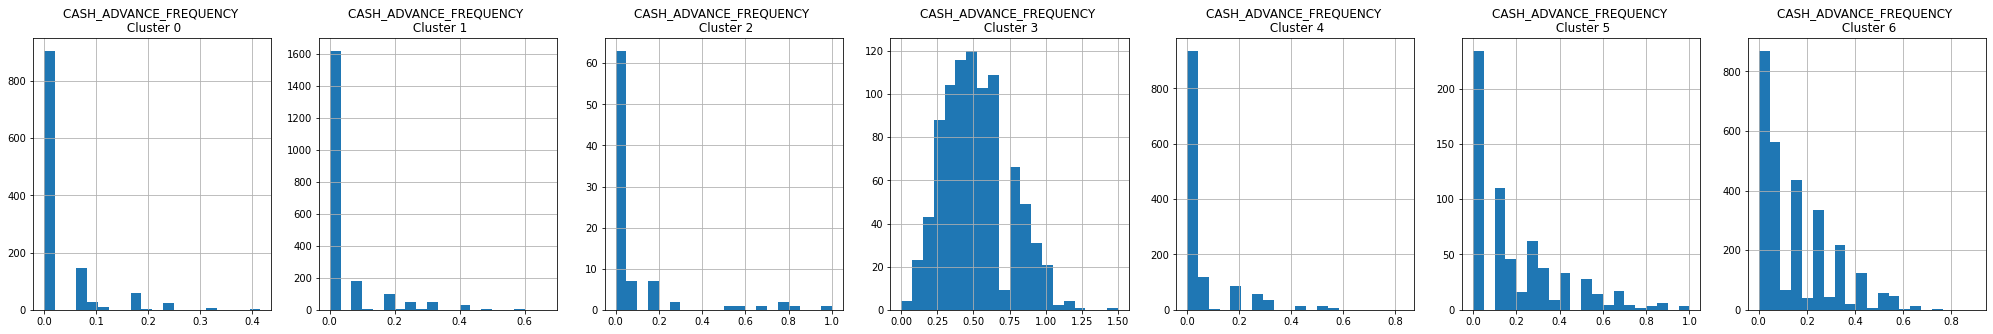

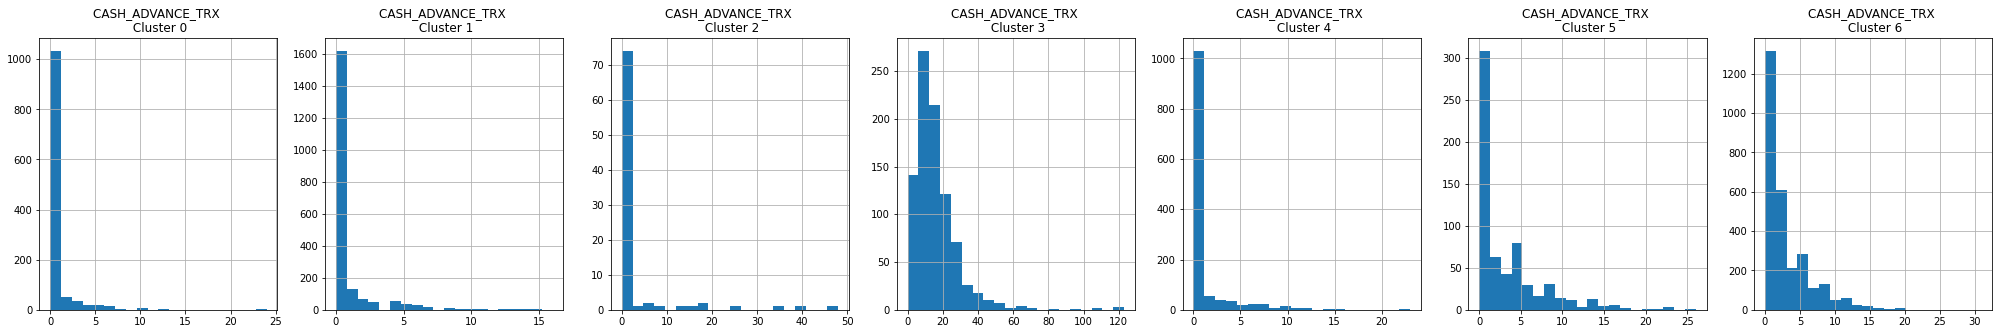

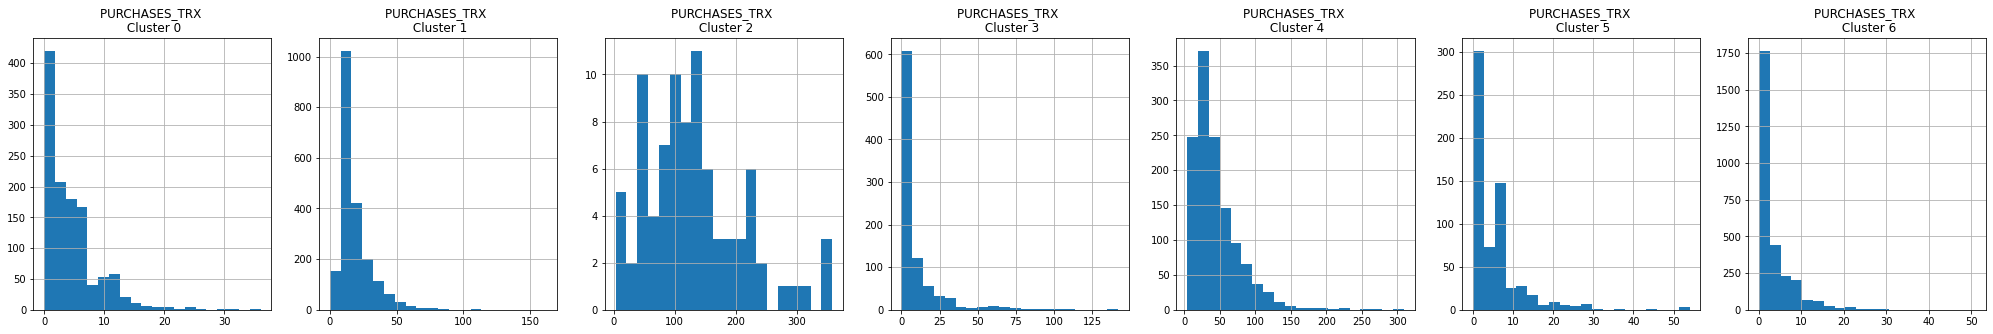

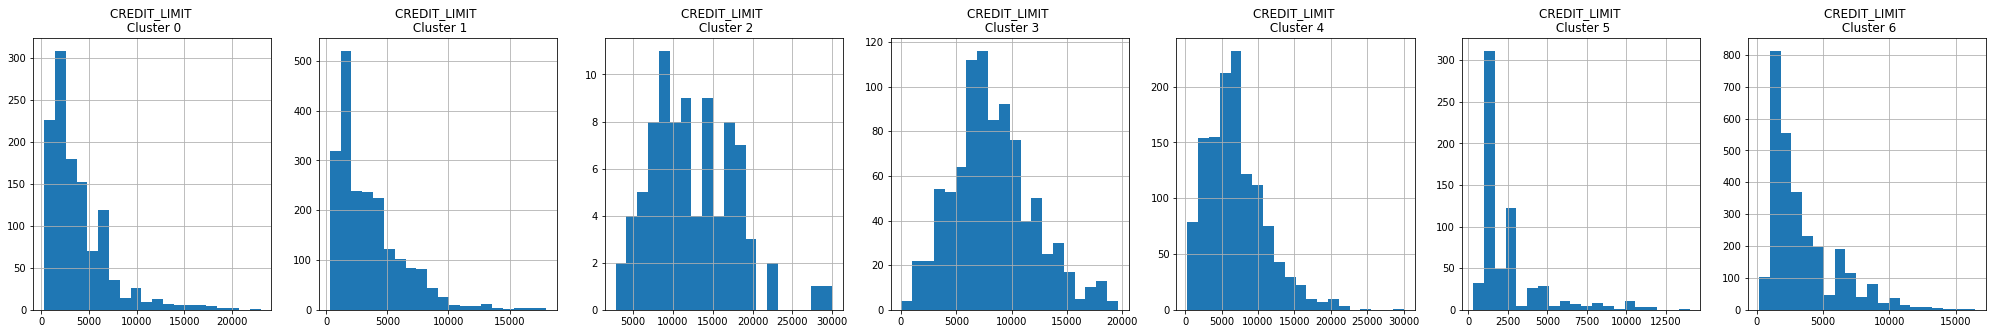

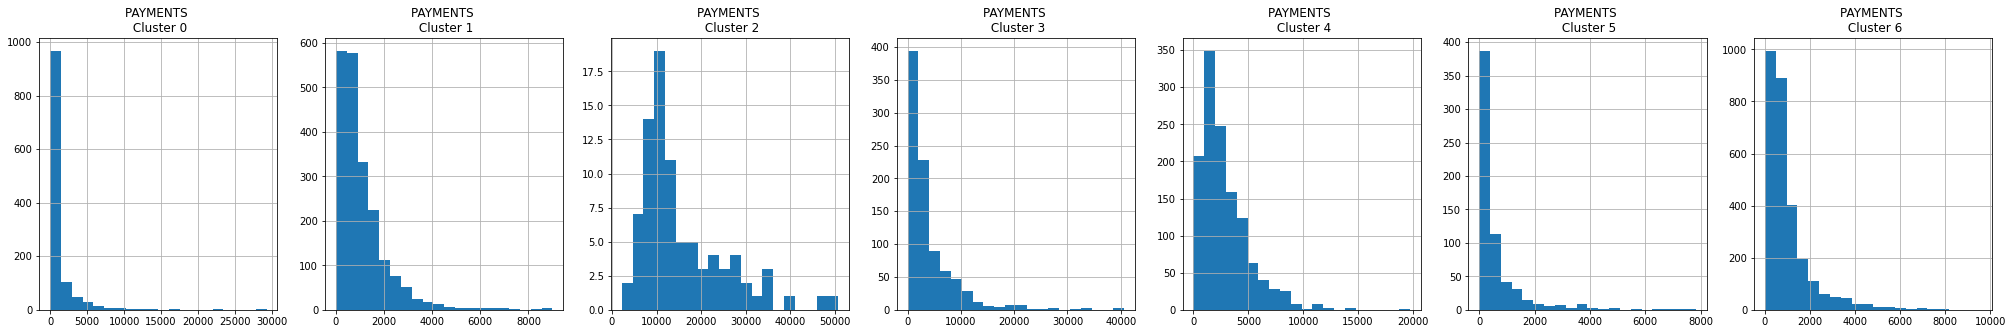

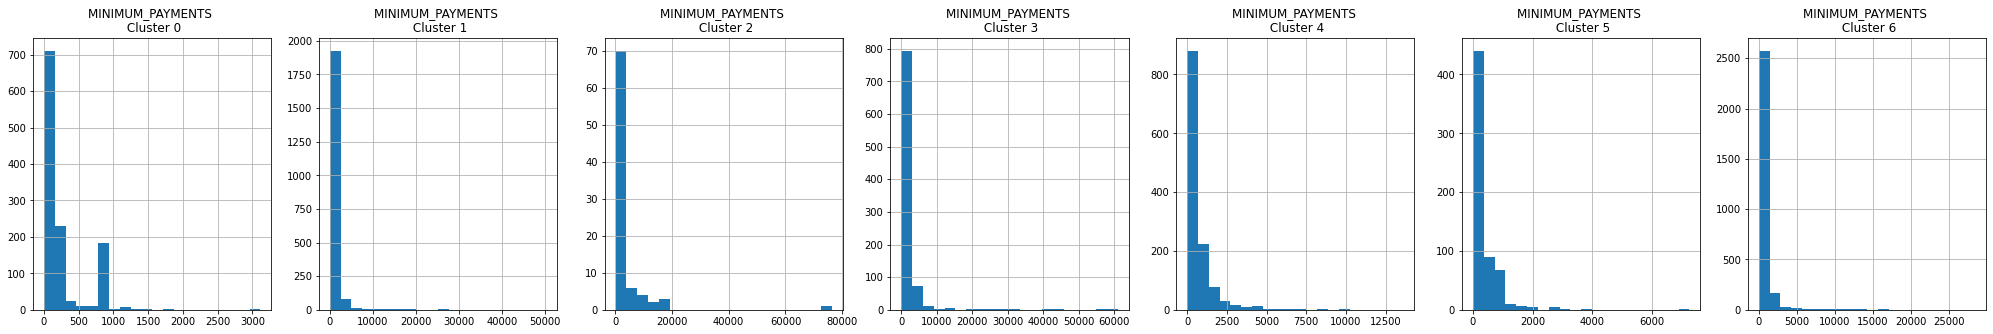

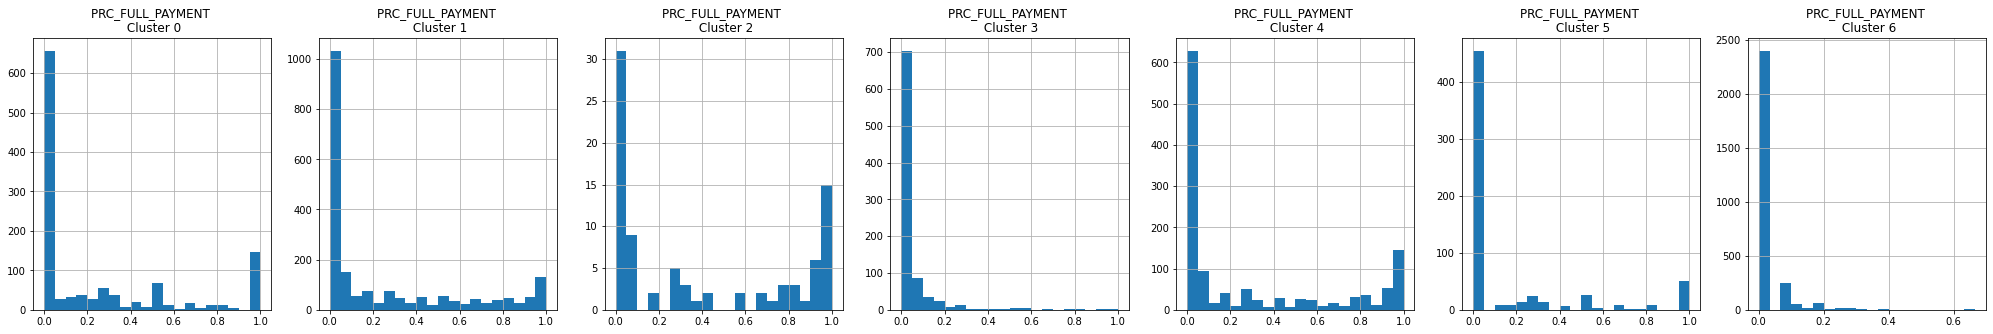

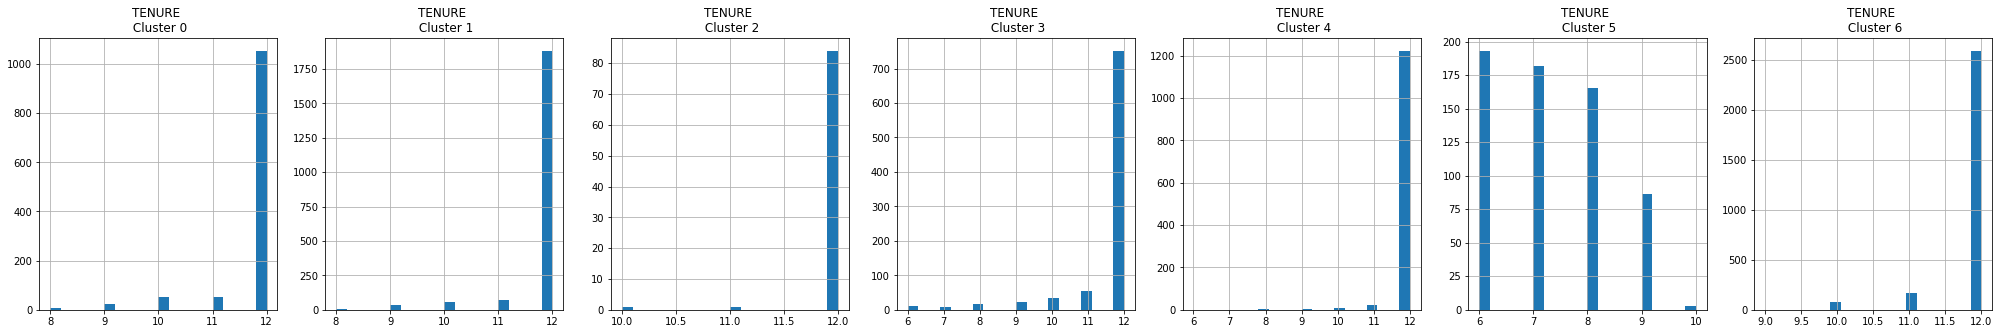

In [5]:
for i in creditcard_df.columns:
  plt.figure(figsize=(35,5))
  for j in range(n_clusters):
    plt.subplot(1, n_clusters, j+1) #número de linhas; colunas; index do gráfico
    cluster = creditcard_df_cluster[creditcard_df_cluster['cluster'] == j] #em cada linha vamos apresentar os atributos específicos para cada um dos grupos
    cluster[i].hist(bins = 20) #Criar histograma | bins = numero de divisões 
    plt.title(f'{i} \n Cluster {j}')
  plt.show()

In [6]:
creditcard_order = creditcard_df_cluster.sort_values(by = 'cluster') #Enviando arquivo com os agrupamentos
creditcard_order.to_csv('creditcard_order.csv', float_format = "%.2f")

## Aplicação de PCA (principal component analysis) e visualização dos resultados

In [7]:
pca = PCA(n_components=2) #número de componentes principais | Vamos transformar 18 características em 2 características
principal_comp = pca.fit_transform(creditcard_scaled_df)
principal_comp

array([[-1.68222006, -1.07644998],
       [-1.13829868,  2.50647126],
       [ 0.96969465, -0.38350716],
       ...,
       [-0.92620311, -1.81078409],
       [-2.33655466, -0.65796903],
       [-0.55642292, -0.40046893]])

In [8]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1','pca2']) #É difícil interpretar esses dados, pois foram realizados vários calculos para defini-los

In [9]:
pca_df = pd.concat([pca_df,
                    pd.DataFrame({'cluster': labels})
                    ], axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-1.682220,-1.076450,6
1,-1.138299,2.506471,3
2,0.969695,-0.383507,4
3,-0.873627,0.043167,6
4,-1.599434,-0.688580,6


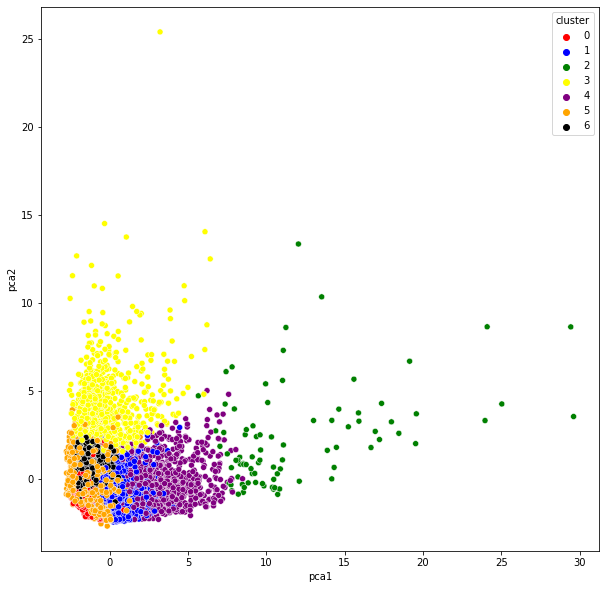

In [10]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red','blue','green','yellow','purple','orange', 'black'])
#Visualização dos grupos

## Aplicação de autoencoders

In [11]:
# Assim como o PCA, vamos reduzir a dimensionalidade dos dados
# 17 -> 10 | Redução de atributos
# Elbow    | Analisar quantos cluster vamos definir
# Kmeans   | Criar novos grupos
# PCA      | Reduzir dimensionalidade dos dados

In [12]:
# 17 -> 500 -> 2000 -> 10 -> 2000 -> 500 -> 17 | o valor 10 é a camada do meio na imagem do README, ou seja, é nela que será armazenado a informação codificada
# Aumentar a quantidade de neurônios (dimensionalidade) é interessante quando se tem poucos dados
from tensorflow.keras.layers import Input, Dense  # | Input = 17 atributos | Dense = uma neurônio será conectado a todos os neurônios da prox camada
from tensorflow.keras.models import Model         # | Construir a estrutura da rede neural

#OBS Poderiamos simplesmente reduzir para 2 dimensões assim como o PCA, porém, queremos unir 2 técnicas distintas

In [13]:
# 17 -> 500 -> 2000 -> 10 -> 2000 -> 500 -> 17
input_df = Input(shape=(17,))                # Camada de input
x = Dense(500, activation='relu')(input_df)  # Camada de 500 neuronios | relu = se valor < 0 então valor = 0
x = Dense(2000, activation='relu')(x)        # Camada de 2000 neuronios
encoded = Dense(10, activation='relu')(x)    # Camada codificada de 10 neuronios
x = Dense(2000, activation='relu')(encoded)  # Camada de 200 neuronios
x = Dense(500, activation='relu')(x)         # Camada de 500 neuronios
decoded = Dense(17)(x)                       # Camada decodificada de 17 neuronios

In [14]:
#Autoencoder
autoencoder = Model(input_df, decoded) #Para criar um modelo precisamos da camada inicial e a camada final

#Encoder
encoder = Model(input_df, encoded)

#Os dados em input_df devem ser muito semelhantes aos dados decodificados em decoded

In [17]:
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error') # Optimizer = ajuste dos pesos | loss = elevar o erro ao quadrado

In [18]:
# Realizar o treinamento
autoencoder.fit(creditcard_scaled_df, creditcard_scaled_df, epochs = 50) #2x porque ele é a entrada e a saída

Epoch 1/50
280/280 [==============================] - 5s 16ms/step - loss: 0.2148
Epoch 2/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0821
Epoch 3/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0520
Epoch 4/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0429
Epoch 5/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0430
Epoch 6/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0631
Epoch 7/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0510
Epoch 8/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0456
Epoch 9/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0277
Epoch 10/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0337
Epoch 11/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0321
Epoch 12/50
280/280 [==============================] - 5s 16ms/step - loss: 0.0545
Epoch 13/50
2

In [20]:
# Realizar a compactação
compact_df = encoder.predict(creditcard_scaled_df)
compact_df.shape, creditcard_scaled_df.shape

((8950, 10), (8950, 17))

In [21]:
#Vamos realizar o teste Elbow Method (Método do cotovelo) calculando o WCSS
wcss_2 = []
range_values = range(1,21)
for i in range_values:
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(compact_df)
  wcss_2.append(kmeans.inertia_)

In [22]:
dif = wcss_2[0]
dif_difs = 0

for cont, i in enumerate(wcss_2):
  dif_ant = round(dif-i, 2)
  dif_difs = round((dif_ant - dif_difs) , 2)
  print(f'{cont+1}º Cluster: {round(i, 2)} | Diferença Cluster anterior: {dif_ant} | Dif da dif {dif_difs}')
  dif = i
  if dif_difs < 0: dif_difs = dif_difs*-1 

1º Cluster: 81326.84 | Diferença Cluster anterior: 0.0 | Dif da dif 0.0
2º Cluster: 61642.56 | Diferença Cluster anterior: 19684.27 | Dif da dif 19684.27
3º Cluster: 50705.66 | Diferença Cluster anterior: 10936.91 | Dif da dif -8747.36
4º Cluster: 45882.76 | Diferença Cluster anterior: 4822.9 | Dif da dif -3924.46
5º Cluster: 42392.86 | Diferença Cluster anterior: 3489.9 | Dif da dif -434.56
6º Cluster: 39295.16 | Diferença Cluster anterior: 3097.7 | Dif da dif 2663.14
7º Cluster: 36390.57 | Diferença Cluster anterior: 2904.59 | Dif da dif 241.45
8º Cluster: 34459.51 | Diferença Cluster anterior: 1931.06 | Dif da dif 1689.61
9º Cluster: 32847.91 | Diferença Cluster anterior: 1611.59 | Dif da dif -78.02
10º Cluster: 31605.87 | Diferença Cluster anterior: 1242.04 | Dif da dif 1164.02
11º Cluster: 30460.07 | Diferença Cluster anterior: 1145.8 | Dif da dif -18.22
12º Cluster: 29284.06 | Diferença Cluster anterior: 1176.02 | Dif da dif 1157.8
13º Cluster: 28369.85 | Diferença Cluster anteri

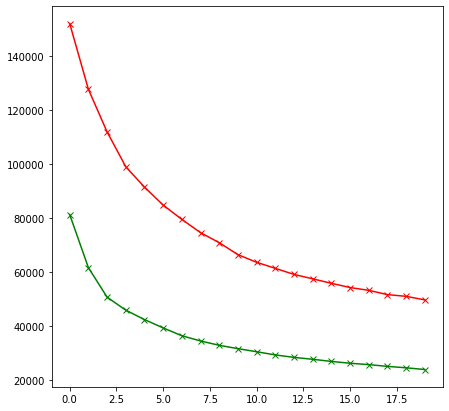

In [26]:
plt.figure(figsize = (7,7))
plt.plot(wcss_1, 'bx-', color = 'r')
plt.plot(wcss_2, 'bx-', color = 'g') # Vamos assumir 4 Clusters

In [28]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(compact_df)
labels = kmeans.labels_
labels, labels.shape

(array([0, 3, 0, ..., 3, 3, 3], dtype=int32), (8950,))

In [29]:
df_cluster_at = pd.concat([creditcard_df, pd.DataFrame({'cluster': labels})], axis=1) # axis1 = Colocar uma coluna ao lado da outra
df_cluster_at.head() # Registros com os clusters correspondentes a cada cliente

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,3
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [30]:
#Separando o dataframe em cada um dos grupos
df_cluster_0 = df_cluster_at[(df_cluster_at['cluster'] == 0)]
df_cluster_1 = df_cluster_at[(df_cluster_at['cluster'] == 1)]
df_cluster_2 = df_cluster_at[(df_cluster_at['cluster'] == 2)]
df_cluster_3 = df_cluster_at[(df_cluster_at['cluster'] == 3)]

In [31]:
df_cluster_0.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.0
mean,1451.184603,0.967749,737.241577,387.976123,349.471289,530.397381,0.520090,0.197343,0.395863,0.119175,2.371642,12.952570,3842.366534,1168.328309,694.460842,0.103334,11.763516,0.0
std,1597.691467,0.089871,975.886740,689.731121,545.436640,901.401894,0.401848,0.290506,0.403381,0.174547,4.048105,16.081999,2871.229588,1206.576862,1049.537486,0.226362,0.854362,0.0
min,0.004816,0.454545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.037744,0.000000,6.000000,0.0
25%,233.163716,1.000000,52.957500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,390.751495,182.336174,0.000000,12.000000,0.0
50%,1031.353932,1.000000,374.070000,38.525000,121.865000,0.000000,0.545455,0.083333,0.300000,0.000000,0.000000,8.000000,3000.000000,768.145098,363.329961,0.000000,12.000000,0.0
75%,1956.016452,1.000000,1012.540000,496.765000,470.487500,768.462977,1.000000,0.250000,0.833333,0.166667,3.000000,17.000000,5500.000000,1498.452255,815.231822,0.083333,12.000000,0.0
max,12474.729540,1.000000,7323.380000,4944.880000,4313.220000,5338.547155,1.000000,1.000000,1.000000,1.125000,34.000000,135.000000,17500.000000,11454.466230,13916.702900,1.000000,12.000000,0.0


In [32]:
df_cluster_1.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.0
mean,4706.923074,0.944665,2664.192903,1784.196544,880.843776,4238.110873,0.531122,0.347266,0.383743,0.347929,11.959410,35.874539,9293.665437,5136.751609,2684.643843,0.124821,11.585486,1.0
std,3325.811417,0.154880,3288.615445,2558.810354,1535.523239,3617.436259,0.423816,0.367643,0.422121,0.297503,14.238973,50.143233,4334.757548,4409.353722,4846.512840,0.270655,1.256171,0.0
min,3.956222,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,16.950090,0.000000,6.000000,1.0
25%,1930.900813,1.000000,0.000000,0.000000,0.000000,298.025242,0.000000,0.000000,0.000000,0.083333,1.000000,0.000000,6000.000000,1917.817732,680.372480,0.000000,12.000000,1.0
50%,4294.953211,1.000000,1065.650000,490.210000,114.000000,4045.620171,0.583333,0.166667,0.166667,0.333333,9.000000,12.000000,9000.000000,3869.748950,1465.870504,0.000000,12.000000,1.0
75%,6912.431438,1.000000,4569.650000,2765.160000,1104.900000,6537.278532,1.000000,0.666667,0.857143,0.583333,17.000000,56.000000,12000.000000,7310.396611,2557.044576,0.083333,12.000000,1.0
max,18495.558550,1.000000,14454.980000,12462.440000,9268.320000,17661.494860,1.000000,1.000000,1.000000,1.500000,123.000000,309.000000,30000.000000,29272.486070,50260.759470,1.000000,12.000000,1.0


In [33]:
df_cluster_2.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.0
mean,5951.063679,0.939736,14145.163548,9974.181129,4170.982419,7721.327819,0.675806,0.493894,0.550922,0.245845,13.548387,84.983871,13566.935484,21049.541381,7096.732076,0.323824,11.870968,2.0
std,4114.006757,0.167856,12784.543993,11393.284231,5347.067478,10716.069087,0.409236,0.418488,0.437352,0.338653,25.923391,100.519388,5426.022179,11282.261667,14908.254682,0.382257,0.689116,0.0
min,198.035504,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3000.000000,302.484224,19.492021,0.000000,7.000000,2.0
25%,2806.187152,1.000000,1555.727500,0.000000,0.000000,0.000000,0.270833,0.000000,0.000000,0.000000,0.000000,5.750000,9125.000000,13185.117405,672.248746,0.000000,12.000000,2.0
50%,4579.157564,1.000000,12584.570000,3702.260000,1310.815000,482.798249,1.000000,0.500000,0.666667,0.083333,1.000000,42.000000,13525.000000,20380.809595,1631.274888,0.166667,12.000000,2.0
75%,8782.148412,1.000000,22470.492500,17674.890000,7542.457500,15037.141517,1.000000,1.000000,1.000000,0.416667,19.750000,125.000000,17000.000000,28073.189902,5423.863334,0.691288,12.000000,2.0
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.000000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000,2.0


In [34]:
df_cluster_3.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.000000,2045.0
mean,516.240657,0.581793,728.668743,437.098988,291.939682,801.121656,0.380827,0.151136,0.258446,0.094282,2.060147,9.346699,4234.206542,1459.837236,452.047358,0.308598,10.753545,3.0
std,944.778952,0.313209,1176.390086,895.842746,609.237809,1415.781244,0.369245,0.261148,0.346118,0.161520,4.231071,16.618830,3510.731473,1984.249064,1347.686373,0.396587,2.068753,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000,3.0
25%,16.933390,0.333333,14.980000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,231.681868,99.372848,0.000000,10.000000,3.0
50%,99.700878,0.545455,237.240000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,4.000000,3000.000000,667.921811,168.814522,0.000000,12.000000,3.0
75%,518.894713,0.875000,898.450000,422.440000,305.780000,1085.168416,0.714286,0.166667,0.500000,0.142857,2.000000,11.000000,6000.000000,1898.347582,444.160316,0.666667,12.000000,3.0
max,7593.590618,1.000000,8273.180000,6520.000000,5368.290000,6481.300951,1.000000,1.000000,1.000000,1.166667,38.000000,154.000000,23000.000000,23150.571840,20316.096310,1.000000,12.000000,3.0


In [35]:
# Aplicando o PCA | 2º redução de dimensionalidade
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(compact_df)
pca_df = pd.DataFrame(data = prin_comp, columns=['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-1.001348,-0.208561
1,2.028846,-1.291544
2,-1.344490,0.652376
3,0.996365,-0.517177
4,-1.554000,0.096777


In [37]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-1.001348,-0.208561,0
1,2.028846,-1.291544,3
2,-1.344490,0.652376,0
3,0.996365,-0.517177,3
4,-1.554000,0.096777,0


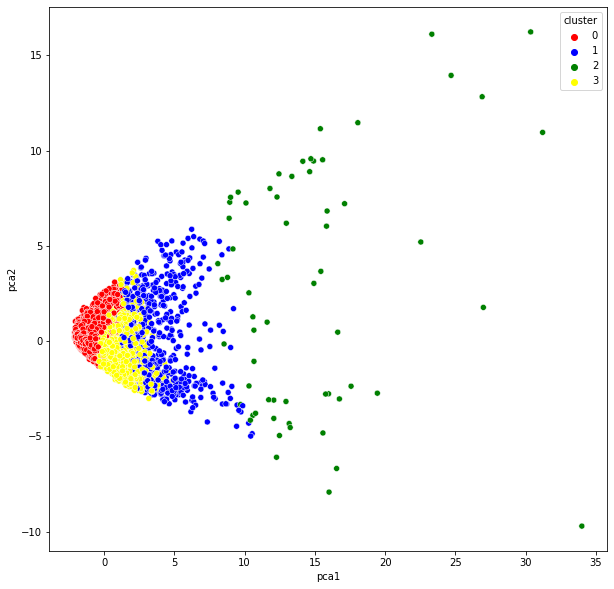

In [38]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red','blue','green','yellow'])
#Visualização dos grupos